# Baixando as bibliotecas

In [1]:
!pip install mlforecast
!pip install dill

# Importando as bibliotecas

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import dill as pickle

import tempfile
import os

import mlforecast
from mlforecast import MLForecast
from utilsforecast.losses import mae, mape, rmse, smape
from utilsforecast.evaluation import evaluate
from utilsforecast.plotting import plot_series


from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt

from mlforecast.auto import (
    AutoLightGBM,
    AutoMLForecast,
    AutoModel,
    AutoRidge,
    ridge_space,
    AutoRandomForest,
    AutoXGBoost,
    AutoLinearRegression,
    AutoLasso,
    AutoElasticNet,
    AutoCatboost,
    xgboost_space,
    catboost_space,
    random_forest_space
)

import warnings
warnings.filterwarnings('ignore')

# Funcoes

In [3]:
def mean_absolute_percentage_error(y_true, y_pred):
      y_true, y_pred = np.array(y_true), np.array(y_pred)
      non_zero_idx = y_true != 0
      return np.mean(np.abs((y_true[non_zero_idx] - y_pred[non_zero_idx]) / y_true[non_zero_idx])) * 100

# Carregando os dados

In [4]:
bucket_uri = "gs://m5_dados/M5_full.parquet"

In [5]:
dados = pd.read_parquet(bucket_uri)

In [6]:
dados['date'] = pd.to_datetime(dados['date'])

In [7]:
last_date = dados['date'].max()

first_day_of_last_month = last_date.replace(day=1)

dados = dados[dados['date'] < first_day_of_last_month]

In [8]:
dados.set_index('date', inplace=True)

# Criando a série temporal de estados

In [9]:
estados = dados.groupby(['state_id']).resample('MS')['value'].sum()

## Split em treino e teste

In [10]:
teste_size = 6
teste = estados.groupby(['state_id']).tail(teste_size)
train = estados.drop(teste.index)

In [11]:
df_train = train.reset_index()
df_test = teste.reset_index()

In [12]:
df_train = df_train.rename(columns={'date': 'ds',
                                    'value': 'y',
                                    'state_id': 'unique_id'})

df_test = df_test.rename(columns={'date': 'ds',
                                  'value': 'y',
                                  'state_id': 'unique_id'})

## Procurando o melhor modelo de previsão

In [13]:
models={
        'lgb': AutoLightGBM(),
         'rf' : AutoRandomForest(),
         'xgb' : AutoXGBoost(),
         'linear' : AutoLinearRegression()
        }

In [14]:
auto_mlf = AutoMLForecast(
    models=models,
    freq="MS",
    season_length=12,
)

In [15]:
auto_mlf.fit(
    df_train,
    n_windows=3,
    h=6,
    num_samples=8
)

[I 2024-07-05 16:21:14,074] A new study created in memory with name: no-name-29b17c71-4cd4-4a4b-8cb0-93d09b96db86
[I 2024-07-05 16:21:14,240] Trial 0 finished with value: 0.026526017942447983 and parameters: {'n_estimators': 169, 'lambda_l1': 0.027334069690310565, 'lambda_l2': 0.0026599310838681858, 'num_leaves': 112, 'feature_fraction': 0.7118273996694524, 'bagging_fraction': 0.8229470565333281, 'objective': 'l2', 'target_transforms_idx': 0, 'lags_idx': 2, 'lag_transforms_idx': 2, 'use_date_features': 0}. Best is trial 0 with value: 0.026526017942447983.
[I 2024-07-05 16:21:14,406] Trial 1 finished with value: 0.025641650604602984 and parameters: {'n_estimators': 422, 'lambda_l1': 1.1600316346542318e-07, 'lambda_l2': 0.005744988873954126, 'num_leaves': 5, 'feature_fraction': 0.972334458524792, 'bagging_fraction': 0.7609241608750359, 'objective': 'l1', 'target_transforms_idx': 0, 'lags_idx': 0, 'lag_transforms_idx': 1, 'use_date_features': 1}. Best is trial 1 with value: 0.025641650604

AutoMLForecast(models={'lgb': AutoModel(model=LGBMRegressor), 'rf': AutoModel(model=RandomForestRegressor), 'xgb': AutoModel(model=XGBRegressor), 'linear': AutoModel(model=LinearRegression)})

In [16]:
preds = auto_mlf.predict(6)

In [17]:
for i in list(models.keys()):
  preds[i] = preds[i].astype(int)

## Analisando o resultado dos modelos por gráficos

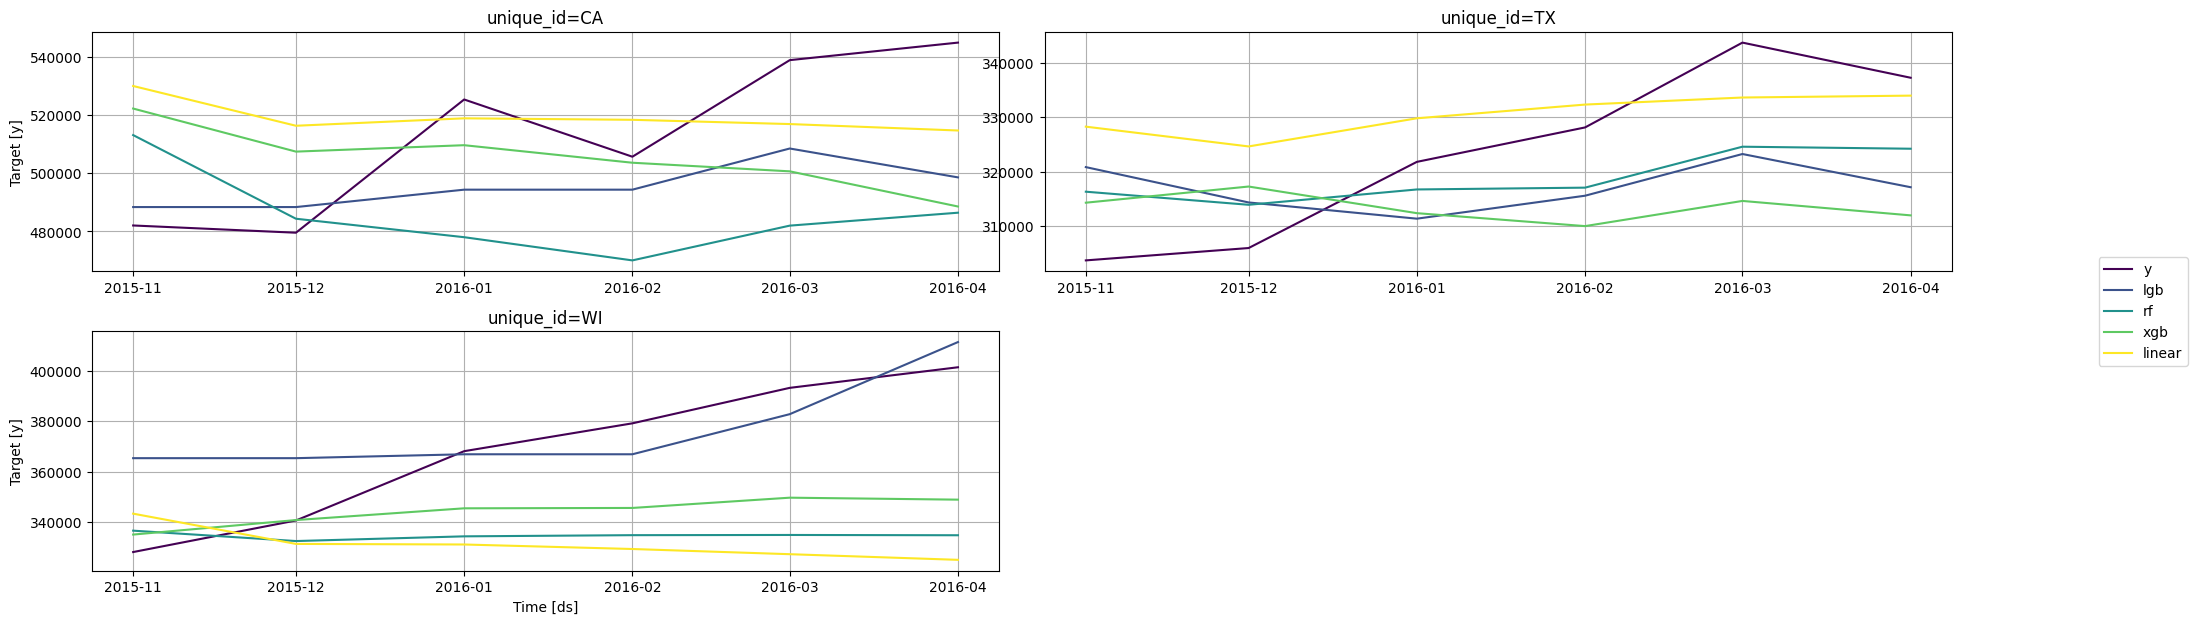

In [18]:
plot_series(df_test, preds, plot_random=False)

## Validando as métricas

In [19]:
previsao_full = df_test.merge(preds, how='right', on=['unique_id', 'ds'])

In [20]:
for i in list(models.keys()):
  print(f'------------------{i}-----------------')
  MAE = mean_absolute_error(df_test['y'], previsao_full[i])
  print(f'Mean Absolute Error: {MAE}')

  MAPE = mean_absolute_percentage_error(df_test['y'], previsao_full[i])
  print(f'Mean absolute percentage error: {MAPE}')

  RMSE = sqrt(mean_squared_error(df_test['y'], previsao_full[i]))
  print(f'Root mean squared error: {RMSE}')

  R2 = r2_score(df_test['y'], previsao_full[i])
  print(f'R2: {R2}')
  print('\n')

------------------lgb-----------------
Mean Absolute Error: 17713.444444444445
Mean absolute percentage error: 4.445202279269464
Root mean squared error: 21183.207180321973
R2: 0.9363560510916217


------------------rf-----------------
Mean Absolute Error: 29015.444444444445
Mean absolute percentage error: 6.836695141942689
Root mean squared error: 35824.90482425134
R2: 0.8179696595383554


------------------xgb-----------------
Mean Absolute Error: 24620.555555555555
Mean absolute percentage error: 5.987757253390551
Root mean squared error: 29564.824363873136
R2: 0.8760278030746091


------------------linear-----------------
Mean Absolute Error: 26549.722222222223
Mean absolute percentage error: 6.612711906291188
Root mean squared error: 33890.97650227532
R2: 0.8370922087110104




In [21]:
tabela_validacao = previsao_full[['unique_id', 'ds', 'y', 'linear']]

## Analisando o desempenho do melhor modelo

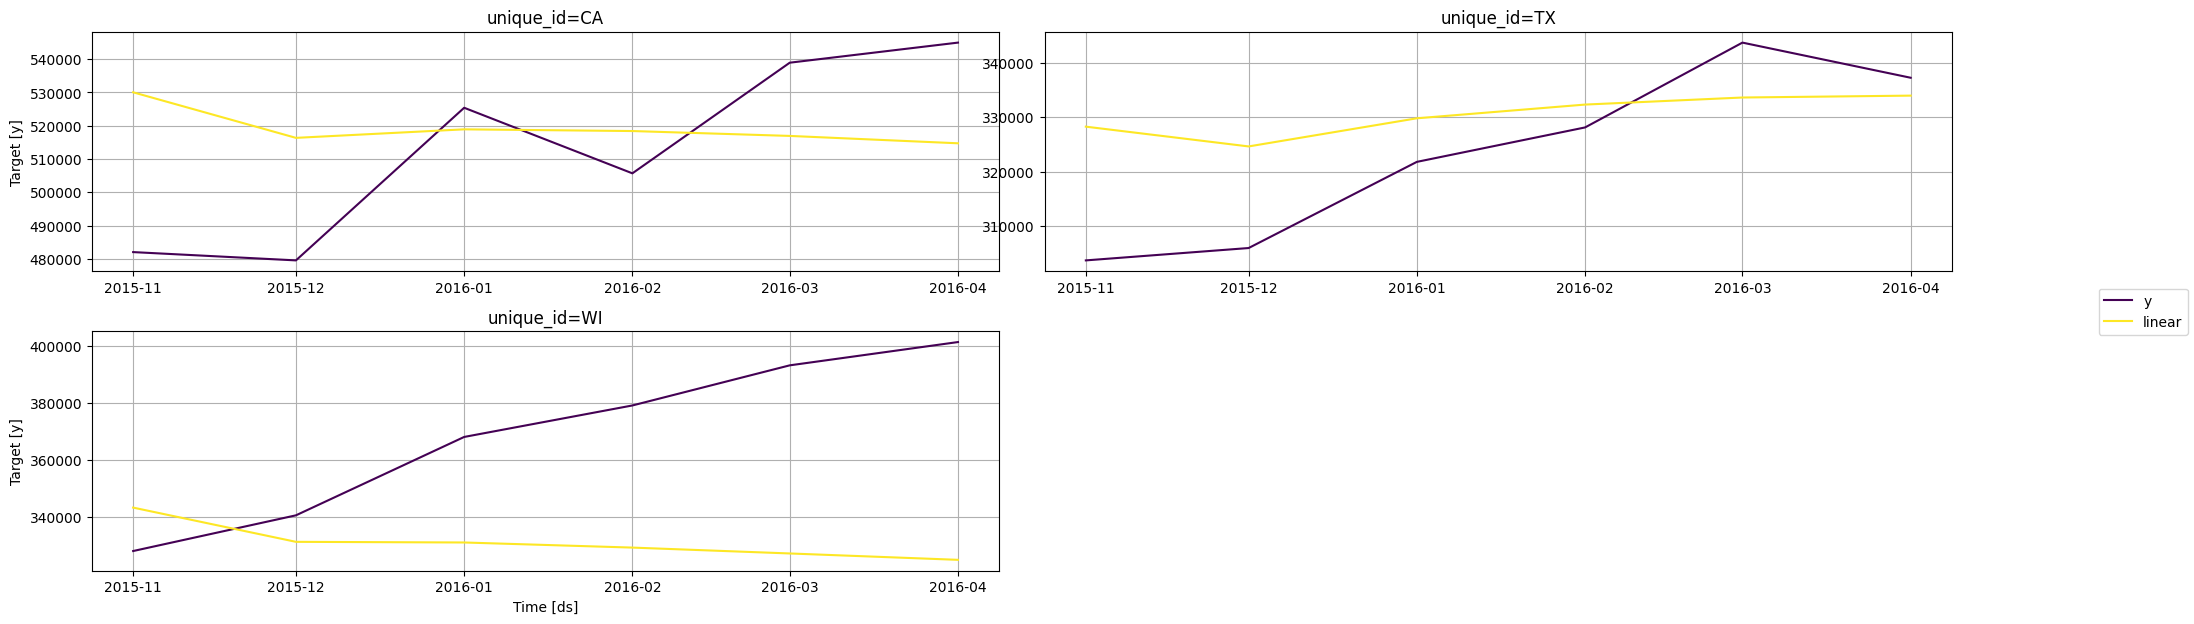

In [22]:
plot_series(df_test, preds[['unique_id', 'ds', 'linear']], plot_random=False)

## Previsão dos próximos 6 meses

In [23]:
models={
         'linear' : AutoLinearRegression()
        }

In [24]:
dados_full = pd.concat([df_train, df_test])

In [25]:
auto_mlf_full = AutoMLForecast(
    models=models,
    freq="MS",
    season_length=12,
)

In [26]:
auto_mlf_full.fit(
    dados_full,
    n_windows=6,
    h=6,
    num_samples=8,
)

[I 2024-07-05 16:21:31,383] A new study created in memory with name: no-name-5422e33c-4e76-46ce-ab15-f715b68e645a
[I 2024-07-05 16:21:31,660] Trial 0 finished with value: 0.04952289486986531 and parameters: {'fit_intercept': False, 'target_transforms_idx': 3, 'lags_idx': 1, 'lag_transforms_idx': 3, 'use_date_features': 0}. Best is trial 0 with value: 0.04952289486986531.
[I 2024-07-05 16:21:31,924] Trial 1 finished with value: 0.03032542540609102 and parameters: {'fit_intercept': True, 'target_transforms_idx': 3, 'lags_idx': 1, 'lag_transforms_idx': 2, 'use_date_features': 0}. Best is trial 1 with value: 0.03032542540609102.
[I 2024-07-05 16:21:32,199] Trial 2 finished with value: 0.03026718658718416 and parameters: {'fit_intercept': False, 'target_transforms_idx': 3, 'lags_idx': 1, 'lag_transforms_idx': 2, 'use_date_features': 1}. Best is trial 2 with value: 0.03026718658718416.
[I 2024-07-05 16:21:32,434] Trial 3 finished with value: 0.06003957073604577 and parameters: {'fit_intercep

AutoMLForecast(models={'linear': AutoModel(model=LinearRegression)})

In [27]:
preds_full = auto_mlf_full.predict(6)

In [28]:
for i in list(models.keys()):
  preds_full[i] = preds_full[i].astype(int)

In [29]:
preds_full.head()

,unique_id,ds,linear
0,CA,2016-05-01,539034
1,CA,2016-06-01,534098
2,CA,2016-07-01,529506
3,CA,2016-08-01,524671
4,CA,2016-09-01,517094


# Exportando os arquivos

# Exportando o pickle

In [30]:
with open('ModelosPKL/estados.pkl', 'wb') as f:
    pickle.dump(auto_mlf_full, f)

# Previsão futuro

In [31]:
preds_full.to_csv('previsao_estados.csv', index=False)

# Validação

In [32]:
tabela_validacao.to_csv('tabela_validacao_estados.csv', index=False)